**Урок 12. Модель Transformer-2**

Задание

Взять тот же датасет, который был на вебинаре и предобученную модель для задачи суммаризации
1. Проверить насколько хорошо она суммаризирует
2.(дополнительно) Сделать генерацию заголовков для статьи (обучить модель для генерации заголовков)


In [1]:
# Установка и загрузка необходимых библиотек

!pip install transformers
!pip install transformers sentencepiece

import numpy as np
import matplotlib.pyplot as plt


import json
import random

!pip install razdel
import razdel
from collections import Counter, namedtuple

!pip install pymorphy2
import pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 28.8 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 31.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 8.2 MB 60.9 MB/s 


In [2]:
# Загрузка данных
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [3]:
# Вспомогательная функция для чтения содержимого датасета

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        # создаем список записей (словарей) из датасета
        for line in r:
            records.append(json.loads(line))
    # сортируем по дате
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    # если требуется - перемешиваем
    if shuffle:
        random.shuffle
    return records

In [4]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [5]:
test_records[0]

{'date': '2020-02-14 16:39:11',
 'summary': 'В NASA назвали четыре миссии в дальний космос, которые в этом десятилетии могут быть запущены американцами. Среди них — две миссии по изучению Венеры, полет к спутнику Юпитера и экспедиция к Тритону, спутнику Нептуна.',
 'text': 'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторы

In [6]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [7]:
Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")
text_stats = Stats(Counter(),  Counter(), list(), list())
text_stats

Stats(vocabulary=Counter(), lemma_vocabulary=Counter(), words_counts=[], unique_words_counts=[])

In [8]:
text_stats.words_counts.append('word')
text_stats

Stats(vocabulary=Counter(), lemma_vocabulary=Counter(), words_counts=['word'], unique_words_counts=[])

In [9]:
# Собираем статистику по данным

Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list()) # Counter работает похоже на Countvectorizer
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        # собираем слова (токены) в Counter (будет токен:количество вхождений)
        stats.vocabulary.update(words)
        # собираем лемматизированные токены в Counter (будет лемм токен:количество вхождений)
        stats.lemma_vocabulary.update(lemmas)
        # в список добавляем количество слов (токенов)
        stats.words_counts.append(len(words))
        #добавляем в список количество уникальных слов (токенов)
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [10]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


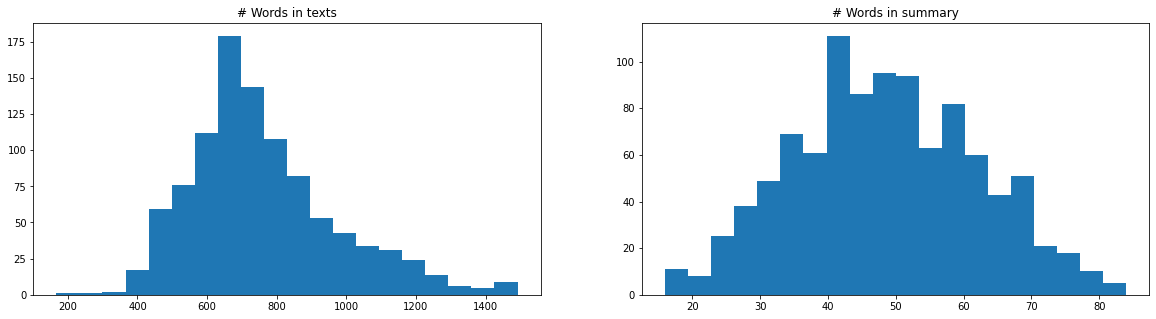

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

**Модель для саммаризации**

In [12]:
random.seed(1)
index = random.randint(0, len(test_records)-1)
test_records[index]

{'date': '2019-10-17 23:12:31',
 'summary': 'Президент The Walt Disney Co. Роберт Айгер возглавил список наиболее влиятельных людей развлекательной индустрии. В топ-100 списка также попали руководители Netflix, телеведущая Опра Уинфри, режиссеры Квентин Тарантино и Джордан Пил, актеры Дуэйн «Скала» Джонсон и Леонардо Ди Каприо, а также экс-президент США Барак Обама.',
 'text': 'Издание The Hollywood Reporter представило рейтинг 100 самых влиятельных людей индустрии развлечений. Возглавил список генеральный директор The Walt Disney Co. Роберт Айгер. Согласно составителям топа, 68-летний уроженец Нью-Йорка в очередной раз стал лидером топа, так как «в Голливуде на данный момент нет человека, который настолько же хорошо сочетал бы в себе коммерческое видение и творческую хватку». В материале также отмечается, что 2019-й можно считать во многом историческим годом для Disney: помимо традиционного для студии успеха ее проектов в прокате, компания недавно пополнилась активами 21st Century Fox

In [13]:
from transformers import AutoTokenizer, MBartForConditionalGeneration #AutoModel

model_name = "IlyaGusev/mbart_ru_sum_gazeta"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.23G [00:00<?, ?B/s]

In [14]:
article_text = test_records[index]['text']

input_ids = tokenizer(
    [article_text],
    max_length=600,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4
)[0]

summary = tokenizer.decode(output_ids, skip_special_tokens=True)
print(summary)

Издание The Hollywood Reporter опубликовало рейтинг 100 самых влиятельных людей индустрии развлечений. Возглавил список генеральный директор The Walt Disney Co. Роберт Айгер — 68-летний уроженец Нью-Йорка в очередной раз стал лидером топа, так как «в Голливуде на данный момент нет человека, который настолько же хорошо сочетал бы в себе коммерческое видение и творческую хватку».


In [15]:
print('True summary:', test_records[index]['summary'])
print('Pred summary:', summary)

True summary: Президент The Walt Disney Co. Роберт Айгер возглавил список наиболее влиятельных людей развлекательной индустрии. В топ-100 списка также попали руководители Netflix, телеведущая Опра Уинфри, режиссеры Квентин Тарантино и Джордан Пил, актеры Дуэйн «Скала» Джонсон и Леонардо Ди Каприо, а также экс-президент США Барак Обама.
Pred summary: Издание The Hollywood Reporter опубликовало рейтинг 100 самых влиятельных людей индустрии развлечений. Возглавил список генеральный директор The Walt Disney Co. Роберт Айгер — 68-летний уроженец Нью-Йорка в очередной раз стал лидером топа, так как «в Голливуде на данный момент нет человека, который настолько же хорошо сочетал бы в себе коммерческое видение и творческую хватку».


В целом, модель отработала весьма неплохо по содержанию

**Генерация заголовков для статьи (обучить модель для генерации заголовков)**

In [16]:
random.seed(2)
index = random.randint(0, len(test_records)-1)
test_records[index]['title'], test_records[index]['text']

('«Имею право обратиться в суд»: Бузова пригрозила Тарасову',
 'Российская поп-певица Ольга Бузова в беседе с поклонниками обмолвилась о том, что все еще может подать на раздел имущества, которое было нажито в браке с футболистом Дмитрием Тарасовым. «По закону я имею право обратиться в суд в течение трех лет после расторжения брака. Данный срок истекает 30 декабря 2019 года. Так что еще не вечер — время есть!» — заявила артистка в рамках онлайн-интервью изданию «СтарХит». На вопрос, были ли со стороны Тарасова попытки наладить общение после развода, Бузова ответила, что они ни разу не виделись после 30 декабря 2016 года, когда официально расторгли брак. «На самом деле он всегда избегает мест, которые посещаю я. Боится, наверное...» — предположила певица. У артистки также спросили, почему она не рассказывает общественности об изменах бывшего мужа. «Они с Настей (нынешняя жена спортсмена Анастасия Костенко — «Газета.Ru») строят из себя святых, каждый раз врут про знакомство. Верни уже их

In [17]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_NAME = "dmitry-vorobiev/rubert_ria_headlines"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)


text = test_records[index]['text']

encoded_batch = tokenizer.prepare_seq2seq_batch(
    [text],
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=512)

output_ids = model.generate(
    input_ids=encoded_batch["input_ids"],
    max_length=36,
    no_repeat_ngram_size=3,
    num_beams=5,
    top_k=0
)

headline = tokenizer.decode(output_ids[0], 
                            skip_special_tokens=True, 
                            clean_up_tokenization_spaces=False)
print(headline)

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790M [00:00<?, ?B/s]

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3557: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


ольга бузова : у него все еще есть право подать на раздел имущества


In [18]:
print('True summary:', test_records[index]['title'])
print('Pred summary:', headline)

True summary: «Имею право обратиться в суд»: Бузова пригрозила Тарасову
Pred summary: ольга бузова : у него все еще есть право подать на раздел имущества


Модель показала хороший результат и заголовок по содержанию похож на правду